In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
from dpeva.uncertain.rnd import RandomNetworkDistillation

Initializing DP-EVA version 0.1.0


## Load descriptor example, 

descriptor shape : (nframe, ndim)

In [ ]:
desc = np.load('../data/desc.npy')
desc.shape

(20873, 136)

## Random Network Distillation

The Random Network Distillation (RND) is a method to learn the representation of the environment and calculate the intrinsic reward of the target data. The idea is to train a neural network to predict the output of a fixed randomly initialized neural network. The fixed network is used to generate the target, and the trainable network is used to predict the target. The intrinsic reward is calculated by the difference between the target and the prediction which is used to train the agent to explore the environment. 

Here in MLIP active learning ,the 'agnet' is our MLIP and the environment is the atomistic space.

In [4]:
%%time
# parameters, can be tuned
input_dim = desc.shape[-1]  # input dimension
output_dim = desc.shape[-1]   # output dimension, no need to be the same as input_dim. here we use the same dimension for simplicity
hidden_dim = 240  # hidden dimension
num_residual_blocks = 1  # number of residual blocks

# initialization
rnd = RandomNetworkDistillation(
            input_dim=input_dim, 
            output_dim=input_dim, 
            hidden_dim=hidden_dim, 
            num_residual_blocks=num_residual_blocks, 
            distance_metric="cossim", 
            use_normalization=False)

# fit the predictor network
rnd.train(desc, 
          num_epochs=40, 
          batch_size=4096, 
          initial_lr=1e-3, 
          gamma=0.90, 
          loss_down_step=5,)

# save the target and predictor networks
# rnd.save_predictor_network("rnd_predictor.pth")
# rnd.save_target_network("rnd_target.pth")

2025-01-10 17:35:24,913 - dpeva.uncertain.rnd - INFO - Epoch 1/40 started, learning rate: 0.001000
2025-01-10 17:35:25,322 - dpeva.uncertain.rnd - INFO - Epoch 1/40 completed, Time: 0.41s, Loss: 0.674519
2025-01-10 17:35:25,323 - dpeva.uncertain.rnd - INFO - Epoch 2/40 started, learning rate: 0.000900
2025-01-10 17:35:25,487 - dpeva.uncertain.rnd - INFO - Epoch 2/40 completed, Time: 0.16s, Loss: 0.115292
2025-01-10 17:35:25,488 - dpeva.uncertain.rnd - INFO - Epoch 3/40 started, learning rate: 0.000900
2025-01-10 17:35:25,662 - dpeva.uncertain.rnd - INFO - Epoch 3/40 completed, Time: 0.17s, Loss: 0.067435
2025-01-10 17:35:25,663 - dpeva.uncertain.rnd - INFO - Epoch 4/40 started, learning rate: 0.000900
2025-01-10 17:35:25,849 - dpeva.uncertain.rnd - INFO - Epoch 4/40 completed, Time: 0.19s, Loss: 0.047779
2025-01-10 17:35:25,850 - dpeva.uncertain.rnd - INFO - Epoch 5/40 started, learning rate: 0.000900
2025-01-10 17:35:26,016 - dpeva.uncertain.rnd - INFO - Epoch 5/40 completed, Time: 0.

CPU times: user 1min 37s, sys: 7.13 s, total: 1min 44s
Wall time: 7.99 s


After training for predictor network, we can use the distance between target network and predictor network as the intrinsic reward for data to be sampled

In [5]:
intrinsic_rewards = []
batch_size = 4096 

# transform intrinsic_rewards to numpy array
intrinsic_rewards = rnd.get_intrinsic_rewards(desc, batch_size=batch_size)

# top 200 unique points
top_200_indices = np.argsort(intrinsic_rewards)[-200:]  
top_200_points = desc[top_200_indices]  

print("Indices of Top 200 points with highest intrinsic rewards:", top_200_indices)

Indices of Top 200 points with highest intrinsic rewards: [10235 13226  7250 19617 16244 19977 12992 14614  5863 18926 13686 20595
 14170 13504  8992 11804  5261 12230 13322 19868 13602  4653  4089 16623
  2413 17596 10729  5588 15172 14564 10037  6886  8276  8751  6839  7014
  7585  6957 10676  6600 15291 18283  5233 11078  7632 11294 18622   803
  6391 15212 17275 18458  7357 11513 15819 11518 20305  9779 14057  7162
  1263  7335 18505  7391  4614  3047  7240  9123 18477 18868  5359  8510
   665  6258 15039 10331  8108 19894 13076 20002 12659  3675 10209  9199
  5247 11752  6764  7347 14033 15543 16890 16980  9394  6481  1699  1075
 12409 17193 20094  5216  4219 12422 12340  5275 15801  9933 12122  1308
  7076  6183 12398 12971 19137 18235  6151 17441  5751 16490 17167   651
 17558  2667  7198  6891 14503  3475  5137  2149  5417 17308 10440 10112
 17269  2402 13812  8817  5235 17520   942 10140  5947  6218 10508 18118
 11798  5319 17442 11629 13013 10576  4352  4274  7055 11687  7861

## Visualizing the uncertainty (reward) results

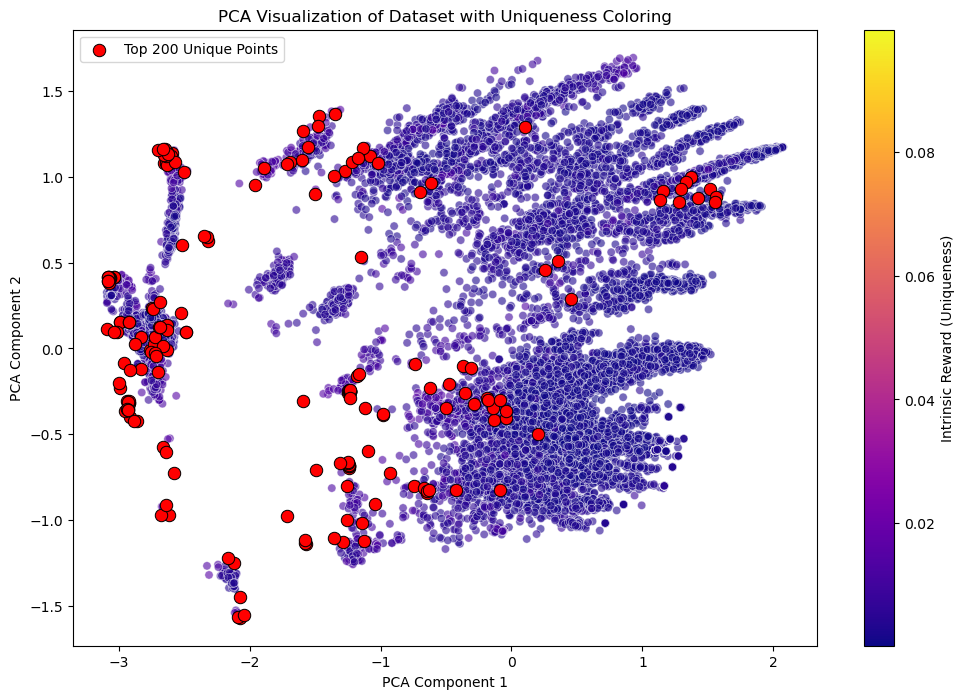

In [6]:
# PCA reduction
pca = PCA(n_components=2) 
pca_result = pca.fit_transform(desc) 
top_200_pca_result = pca.transform(top_200_points) # PCA reduction for top 200 unique points in the same space

plt.figure(figsize=(12, 8))

ax = sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=intrinsic_rewards, palette="plasma", alpha=0.6, legend=False
)

sns.scatterplot(
    x=top_200_pca_result[:, 0], y=top_200_pca_result[:, 1],
    color="red", label="Top 200 Unique Points", s=80, edgecolor="black"
)

norm = plt.Normalize(intrinsic_rewards.min(), intrinsic_rewards.max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Intrinsic Reward (Uniqueness)")  # 指定 ax 参数

# 添加标题和标签
plt.title("PCA Visualization of Dataset with Uniqueness Coloring")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

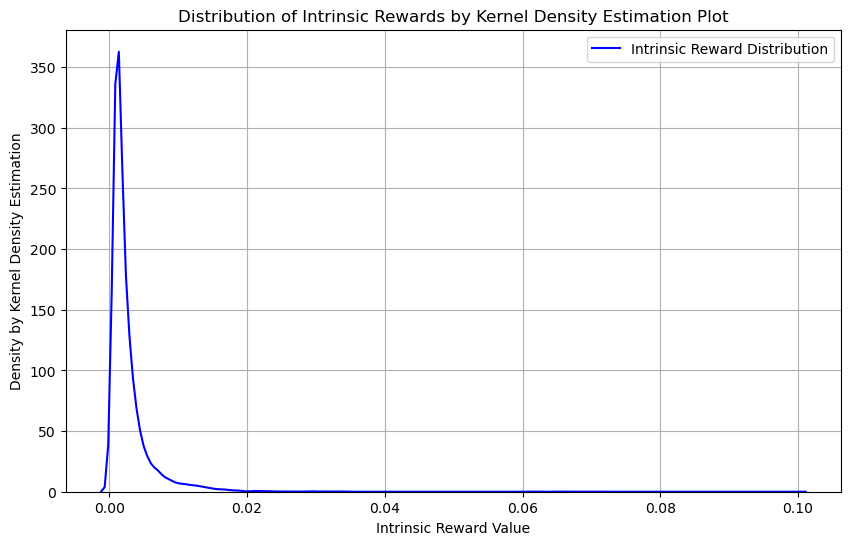

In [7]:
plt.figure(figsize=(10, 6))
sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 
plt.title("Distribution of Intrinsic Rewards by Kernel Density Estimation Plot")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density by Kernel Density Estimation")
plt.legend()
plt.grid(True)
plt.show()

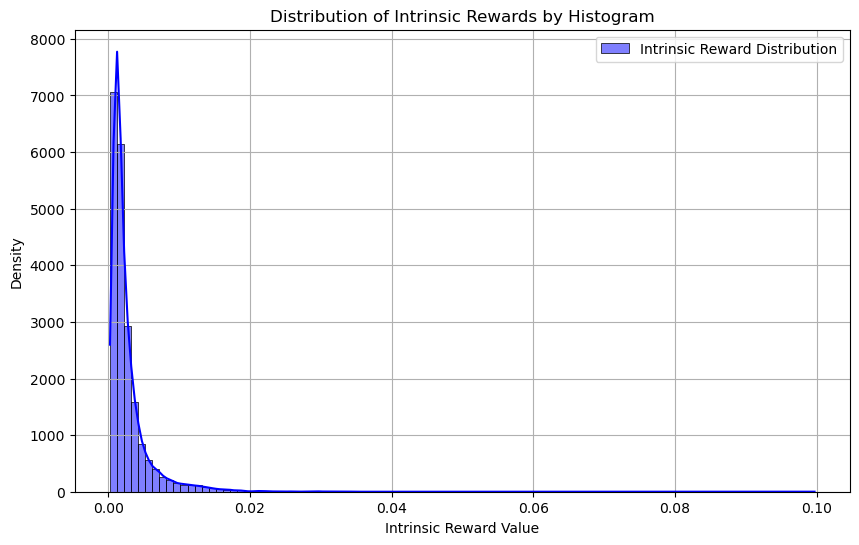

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution", bins=100, kde=True)
plt.title("Distribution of Intrinsic Rewards by Histogram")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()